In [1]:
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt
import geopandas
import censusdata
import numpy as np
import seaborn as sns
import bokeh
import us
from census import Census
from bokeh.plotting import ColumnDataSource, figure, show, output_file
from bokeh.layouts import gridplot, column, row, WidgetBox
from bokeh.models import Panel, CustomJS, Div, Select
from ipywidgets import interact, interact_manual, Dropdown
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [2]:
# set path 
path = r'C:\Users\engel\Documents\GitHub\Data-II-Project'
# path = r'/Users/bowenli/Documents/GitHub/Data-II-Project'
# path = r'C:/Users/ShrekTheOger/Documents/GitHub/Data-II-Project'

In [189]:
# set float display
pd.options.display.float_format = '{:.2f}'.format

## Read Data using API 

In [134]:
# references 
# https://towardsdatascience.com/mapping-us-census-data-with-python-607df3de4b9c
# https://pypi.org/project/CensusData/
# https://towardsdatascience.com/using-the-us-census-api-for-data-analysis-a-beginners-guide-98063791785c

# function for retrieving population data
def get_acs5_county_population(year):
    data = censusdata.download('acs5', year, censusdata.censusgeo([('county', '*')]),
                               ['B05002_001E', 'B05002_002E', 'B05002_003E', 'B05002_004E', 'B05002_009E', 'B05002_013E'])
    
    # create dictionary for the column names
    column_names = {'B05002_001E': 'total_population', 'B05002_002E': 'total_native', 
                    'B05002_003E': 'total_born_in_state', 'B05002_004E': 'total_born_out_state',
                    'B05002_009E': 'total_born_outside_US', 'B05002_013E': 'total_foreign_born'}
    
    # create new column for county name and state name, the index would be FIPS codes 
    new_indices = []
    county_names = []
    county_ids = []
    state_names = []
    state_ids = []
    
    
    for index in data.index.tolist():
        new_index = index.geo[0][1] + index.geo[1][1]
        new_indices.append(new_index)
        county_name = index.name.split(',')[0]
        county_names.append(county_name)
        state_name = index.name.split(',')[1]
        state_names.append(state_name)
        state_id = index.geo[0][1]
        state_ids.append(state_id)
        county_id = index.geo[1][1]
        county_ids.append(county_id)

    data.index = new_indices
    data['county_name'] = county_names
    data['state_name'] = state_names
    data['county_id'] = county_ids
    data['state_id'] =  state_ids
    data['year'] =  year
    
    # replace column names 
    data = data[['year', 'state_name', 'county_name', 'state_id', 'county_id', 'B05002_001E',
                 'B05002_002E', 'B05002_003E', 'B05002_004E', 'B05002_009E', 'B05002_013E']]
    data = data.rename(column_names, axis=1) 
    
    # define data type
    data['year'].astype(float)
    data.iloc[:,1:3] = data.iloc[:,1:3].astype('str')
    data.iloc[:,3:] = data.iloc[:,3:].astype(float)
    data['state_name'] = data['state_name'].str.strip()
    
    return data

In [4]:
# function for retrieving income data
def get_acs5_county_income(year):
    data = censusdata.download('acs5', year, censusdata.censusgeo([('county', '*')]), ['B19301_001E'])
    
    # create dictionary for the column names
    column_names = {'B19301_001E': 'income_past12m'}
    
    # create new column for county name and state name, the index would be FIPS codes 
    new_indices = []
    county_names = []
    county_ids = []
    state_names = []
    state_ids = []
    
    for index in data.index.tolist():
        new_index = index.geo[0][1] + index.geo[1][1]
        new_indices.append(new_index)
        county_name = index.name.split(',')[0]
        county_names.append(county_name)
        state_name = index.name.split(',')[1]
        state_names.append(state_name)
        state_id = index.geo[0][1]
        state_ids.append(state_id)
        county_id = index.geo[1][1]
        county_ids.append(county_id)

    data.index = new_indices
    data['county_name'] = county_names
    data['state_name'] = state_names
    data['county_id'] = county_ids
    data['state_id'] =  state_ids
    data['year'] =  year
    
    # replace column names 
    data = data[['year', 'state_name', 'county_name', 'state_id', 'county_id', 'B19301_001E']]
    data = data.rename(column_names, axis=1) 
    return data

In [5]:
# create list of years that we would like to assess
years = list(range(2010, 2020))

In [299]:
# create dataframe of population from 2010 to 2019
df_population = pd.DataFrame()

for year in years: 
    population_year = get_acs5_county_population(year) 
    df_population = df_population.append(population_year)

df_population = df_population.reset_index()

In [269]:
# create dataframe of income from 2010 to 2019
df_income = pd.DataFrame()

for year in years: 
    income_year = get_acs5_county_income(year) 
    df_income = df_income.append(income_year)

df_income = df_income.reset_index()

## Creating Line Plots 

In [141]:
# function to generate color
def color_gen(n):
    palette = bokeh.palettes.cividis(n)
    for color in palette:
        yield color

In [ ]:
# create plot with multiple lines
def plot_multiline(df, xaxis, yaxis, hue, title):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 10)
    sns.set_theme(style='whitegrid')
    
    graph = sns.lineplot(data=df, x=xaxis, y=yaxis, hue=hue, style=hue, markers=True);
    graph.legend(loc='center left', bbox_to_anchor=(1.00, 0.5), ncol=1);
    graph.set(title=title, ylabel='natural units');
    
    return graph

In [ ]:
# function for interactive plot using Bokeh        
def plot_variable(df, institution, variable):
    data = df.loc[df['inst_name'] == institution]
    source = ColumnDataSource(data=data)
    
    tool = [('value', '@'+variable), ('year','@year')]
    plot = figure(title=institution, x_axis_label='Year', y_axis_label='natural units', 
                  tooltips=tool, plot_height=400)
    plot.line(x='year', y=variable, source=source, color=next(get_color))
    plot.circle(x='year', y=variable, source=source, color='grey')
    
    return plot

In [ ]:
# return US state name in contiguous
states = [state.name for state in us.STATES_CONTIGUOUS]

In [136]:
# filter income based on State and County

def filter_state_county(df, state, county): 
    df['state_name'].str.lstrip()
    data = df[(df['state_name'] == state) & (df['county_name'] == county)]
    return data

In [217]:
# https://stackoverflow.com/questions/32573452/settingwithcopywarning-even-when-using-locrow-indexer-col-indexer-value
population_filter = filter_state_county(df_population, 'Illinois', 'Cook County').copy()

In [102]:
df_population.dtypes

year                       int64
state_name                object
county_name               object
state_id                 float64
county_id                float64
total_population         float64
total_native             float64
total_born_in_state      float64
total_born_out_state     float64
total_born_outside_US    float64
total_foreign_born       float64
dtype: object

In [218]:
population_filter

,year,state_name,county_name,state_id,county_id,total_population,total_native,total_born_in_state,total_born_out_state,total_born_outside_US,total_foreign_born
17031,2010,Illinois,Cook County,17.00,31.00,5172848.00,4085967.00,3168508.00,847240.00,70219.00,1086881.00
17031,2011,Illinois,Cook County,17.00,31.00,5182969.00,4092973.00,3175519.00,844343.00,73111.00,1089996.00
17031,2012,Illinois,Cook County,17.00,31.00,5197677.00,4098252.00,3186629.00,836550.00,75073.00,1099425.00
17031,2013,Illinois,Cook County,17.00,31.00,5212372.00,4113454.00,3205604.00,832394.00,75456.00,1098918.00
17031,2014,Illinois,Cook County,17.00,31.00,5227827.00,4126072.00,3220139.00,828693.00,77240.00,1101755.00
17031,2015,Illinois,Cook County,17.00,31.00,5236393.00,4127954.00,3224748.00,825134.00,78072.00,1108439.00
17031,2016,Illinois,Cook County,17.00,31.00,5227575.00,4125845.00,3222677.00,824586.00,78582.00,1101730.00
17031,2017,Illinois,Cook County,17.00,31.00,5238541.00,4133162.00,3230676.00,822928.00,79558.00,1105379.00
17031,2018,Illinois,Cook County,17.00,31.00,5223719.00,4124060.00,3217517.00,824977.00,81566.00,1099659.00
17031,2019,Illinois,Cook County,17.00,31.00,5198275.00,4099447.00,3198804.00,819189.00,81454.00,1098828.00


In [263]:
population_filter.reset_index()

,index,year,state_name,county_name,state_id,county_id,total_population,total_native,total_born_in_state,total_born_out_state,total_born_outside_US,total_foreign_born,share_in_state
0,17031,2010,Illinois,Cook County,17.00,31.00,5172848.00,4085967.00,3168508.00,847240.00,70219.00,1086881.00,0.61
1,17031,2011,Illinois,Cook County,17.00,31.00,5182969.00,4092973.00,3175519.00,844343.00,73111.00,1089996.00,0.61
2,17031,2012,Illinois,Cook County,17.00,31.00,5197677.00,4098252.00,3186629.00,836550.00,75073.00,1099425.00,0.61
3,17031,2013,Illinois,Cook County,17.00,31.00,5212372.00,4113454.00,3205604.00,832394.00,75456.00,1098918.00,0.61
4,17031,2014,Illinois,Cook County,17.00,31.00,5227827.00,4126072.00,3220139.00,828693.00,77240.00,1101755.00,0.62
5,17031,2015,Illinois,Cook County,17.00,31.00,5236393.00,4127954.00,3224748.00,825134.00,78072.00,1108439.00,0.62
6,17031,2016,Illinois,Cook County,17.00,31.00,5227575.00,4125845.00,3222677.00,824586.00,78582.00,1101730.00,0.62
7,17031,2017,Illinois,Cook County,17.00,31.00,5238541.00,4133162.00,3230676.00,822928.00,79558.00,1105379.00,0.62
8,17031,2018,Illinois,Cook County,17.00,31.00,5223719.00,4124060.00,3217517.00,824977.00,81566.00,1099659.00,0.62
9,17031,2019,Illinois,Cook County,17.00,31.00,5198275.00,4099447.00,3198804.00,819189.00,81454.00,1098828.00,0.62


In [227]:
pop_variables = ['total_born_in_state', 'total_born_out_state', 'total_born_outside_US', 'total_foreign_born']
get_color = color_gen(len(pop_variables))


In [222]:
population_filter['share_in_state'] = (population_filter['total_born_in_state']/population_filter['total_population'])

In [223]:
population_filter

,year,state_name,county_name,state_id,county_id,total_population,total_native,total_born_in_state,total_born_out_state,total_born_outside_US,total_foreign_born,share_in_state
17031,2010,Illinois,Cook County,17.00,31.00,5172848.00,4085967.00,3168508.00,847240.00,70219.00,1086881.00,0.61
17031,2011,Illinois,Cook County,17.00,31.00,5182969.00,4092973.00,3175519.00,844343.00,73111.00,1089996.00,0.61
17031,2012,Illinois,Cook County,17.00,31.00,5197677.00,4098252.00,3186629.00,836550.00,75073.00,1099425.00,0.61
17031,2013,Illinois,Cook County,17.00,31.00,5212372.00,4113454.00,3205604.00,832394.00,75456.00,1098918.00,0.61
17031,2014,Illinois,Cook County,17.00,31.00,5227827.00,4126072.00,3220139.00,828693.00,77240.00,1101755.00,0.62
17031,2015,Illinois,Cook County,17.00,31.00,5236393.00,4127954.00,3224748.00,825134.00,78072.00,1108439.00,0.62
17031,2016,Illinois,Cook County,17.00,31.00,5227575.00,4125845.00,3222677.00,824586.00,78582.00,1101730.00,0.62
17031,2017,Illinois,Cook County,17.00,31.00,5238541.00,4133162.00,3230676.00,822928.00,79558.00,1105379.00,0.62
17031,2018,Illinois,Cook County,17.00,31.00,5223719.00,4124060.00,3217517.00,824977.00,81566.00,1099659.00,0.62
17031,2019,Illinois,Cook County,17.00,31.00,5198275.00,4099447.00,3198804.00,819189.00,81454.00,1098828.00,0.62


In [230]:
data = pd.DataFrame()
data['total_born_in_state'] = (population_filter['total_born_in_state']/population_filter['total_population'])
data['total_born_out_state'] = (population_filter['total_born_out_state']/population_filter['total_population'])
data['total_born_outside_US'] = (population_filter['total_born_outside_US']/population_filter['total_population'])
data['total_foreign_born'] = (population_filter['total_foreign_born']/population_filter['total_population'])

In [231]:
data

,total_born_in_state,total_born_out_state,total_born_outside_US,total_foreign_born
17031,0.61,0.16,0.01,0.21
17031,0.61,0.16,0.01,0.21
17031,0.61,0.16,0.01,0.21
17031,0.61,0.16,0.01,0.21
17031,0.62,0.16,0.01,0.21
17031,0.62,0.16,0.01,0.21
17031,0.62,0.16,0.02,0.21
17031,0.62,0.16,0.02,0.21
17031,0.62,0.16,0.02,0.21
17031,0.62,0.16,0.02,0.21


In [228]:
def plot_stackedbar(df, variables, title):
    #data = df
    data = pd.DataFrame()
    data['year'] = df['year']
    data['total_born_in_state'] = (df['total_born_in_state']/df['total_population'])
    data['total_born_out_state'] = (df['total_born_out_state']/df['total_population'])
    data['total_born_outside_US'] = (df['total_born_outside_US']/df['total_population'])
    data['total_foreign_born'] = (df['total_foreign_born']/df['total_population'])
    selected_data = data[['year', *variables]]
    selected_data = selected_data.sort_values('year', ascending = True).reset_index(drop=True)
    
    selected_data.plot(x='year', kind='bar', figsize=(12, 10), stacked=True, color=get_color)
    plt.legend(title='category', bbox_to_anchor=(1.3,0.5), loc='center right')
    plt.ylim(0.0, 1.0)
    plt.title(title, fontsize=20)
    plt.xticks(rotation=0, fontsize=12)
    plt.ylabel('natural units', fontsize=15)
    plt.xlabel('year', fontsize=15)
    
    return plt

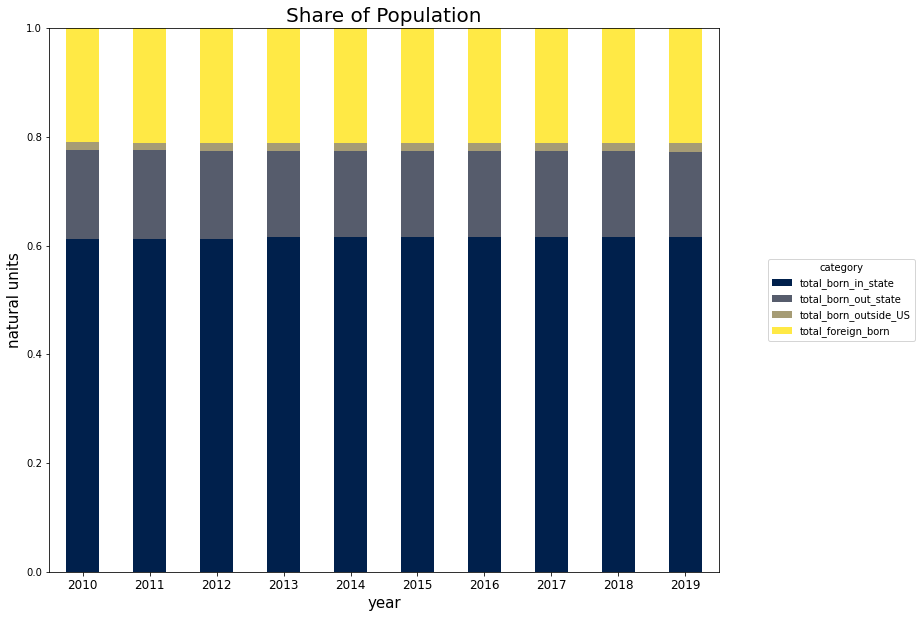

In [229]:
plot_stackedbar(population_filter, pop_variables, 'Share of Population');

In [153]:
source = ColumnDataSource(data=population_filter)
    
tool = [('value', '@'+'total_population'), ('year','@year')]

plot = figure(title='Merced County', x_axis_label='year', y_axis_label='natural units', tooltips=tool, plot_height=400)
    
plot.line(x='year', y='total_population', source=source, color='blue')
plot.circle(x='year', y='total_population', source=source, color='grey')

show(plot)

## Creating Regression 

In [ ]:
# regression income on population and r&d funding 

In [246]:
# Read Universities R&D Data based on ID 
# # https://stackoverflow.com/questions/45416684/python-pandas-replace-multiple-columns-zero-to-nan
rd_id = os.path.join(path, 'NCSES', 'HERD_data_IPEDS.csv')
rd_id_data = pd.read_csv(rd_id, skiprows=10)


rd_id_data = rd_id_data.iloc[2:]
column_names_id = {'Unnamed: 0': 'state_name', '<Fiscal Year>': 'IPEDSID'}
rd_id_data = rd_id_data.rename(column_names_id, axis=1) 
rd_id_data = rd_id_data[rd_id_data['IPEDSID'].str.contains('Total for selected values') == False]
rd_id_data = rd_id_data[rd_id_data['IPEDSID'].str.contains('No match or exact match for IPEDS UnitID') == False]
rd_id_data.iloc[:,2:] = rd_id_data.iloc[:,2:].replace({'-':np.nan}).replace(r',','',regex=True)
rd_id_data.iloc[:,2:] = rd_id_data.iloc[:,2:].astype(float)
rd_id_data  = rd_id_data.sort_values(['2010'], ascending = False)

rd_id_data = rd_id_data.head(50)

rd_id_data = rd_id_data.reset_index(drop = True)

years_string = [str(year) for year in years]

rd_id_data = rd_id_data[['state_name', 'IPEDSID', *years_string]]

In [247]:
rd_id_data

,state_name,IPEDSID,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Maryland,162928,2085599.00,2186454.00,2106185.00,2131165.00,2162885.00,2200312.00,2294982.00,2373646.00,2416268.00,2597238.00
1,Michigan,170976,1232377.00,1303656.00,1322711.00,1351399.00,1301372.00,1306704.00,1355976.00,1417476.00,1453619.00,1491880.00
2,Wisconsin,240444,1070948.00,1132963.00,1169779.00,1104123.00,1069218.00,1020221.00,1092825.00,1105543.00,1094633.00,1154945.00
3,Washington,236948,1064128.00,1170561.00,1109008.00,1171945.00,1134588.00,1126613.00,1206102.00,1248951.00,1283849.00,1269137.00
4,North Carolina,198419,1023081.00,1041812.00,1009911.00,975697.00,1000013.00,989322.00,996632.00,1043949.00,1060213.00,1091903.00
5,California,110680,981389.00,1028737.00,1073864.00,1057003.00,1029503.00,1051130.00,1026215.00,1049998.00,1148822.00,1205183.00
6,California,110662,974913.00,1001198.00,1003375.00,949986.00,914543.00,974558.00,979404.00,997624.00,1196868.00,1162997.00
7,California,110699,973367.00,1014314.00,1032673.00,1024854.00,1045555.00,1075135.00,1221755.00,1305625.00,1448954.00,1420031.00
8,California,243744,873826.00,925385.00,903238.00,929143.00,925200.00,975822.00,1006535.00,1028001.00,1051120.00,1071960.00
9,Pennsylvania,215062,870166.00,903030.00,847077.00,814134.00,798949.00,824581.00,1223801.00,1273105.00,1309300.00,1340965.00


In [249]:
top50_id = rd_id_data['IPEDSID'].unique()
top50_id

array(['162928', '170976', '240444', '236948', '198419', '110680',
       '110662', '110699', '243744', '215062', '215293', '190150',
       '174066', '214777', '199120', '190415', '179867', '110635',
       '228723', '134130', '110644', '166683', '130794', '139755',
       '416801', '123961', '228778', '104179', '166027', '147767',
       '243780', '139658', '145637', '221999', '100663', '163286',
       '223223', '153658', '144050', '171100', '186380', '228635',
       '201645', '195030', '233921', '126562', '137351', '230764',
       '163259', '193405'], dtype=object)

In [232]:
# universities data
universities_shp = os.path.join(path, 'Colleges_and_Universities-shp', 'Colleges_and_Universities.shp')
universities = geopandas.read_file(universities_shp)

In [233]:
universities

,OBJECTID,IPEDSID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,...,SIZE_SET,INST_SIZE,PT_ENROLL,FT_ENROLL,TOT_ENROLL,HOUSING,DORM_CAP,TOT_EMP,SHELTER_ID,geometry
0,1,189556,BRYANT & STRATTON COLLEGE-AMHERST,3650 MILLERSPORT HIGHWAY,GETZVILLE,NY,14068,NOT AVAILABLE,(716) 625-6300,3,...,6,1,141,176,317,2,-999,79,NOT AVAILABLE,POINT (-8765604.528 5318191.756)
1,2,190682,CUNY SCHOOL OF LAW,2 COURT SQUARE,LONG ISLAND CITY,NY,11101,NOT AVAILABLE,(718) 340-4200,1,...,18,1,165,418,583,2,-999,201,NOT AVAILABLE,POINT (-8231382.708 4975222.417)
2,3,195058,ROCKLAND COMMUNITY COLLEGE,145 COLLEGE RD,SUFFERN,NY,10901,3699,(845) 574-4000,1,...,3,3,3317,3542,6859,2,-999,901,NOT AVAILABLE,POINT (-8247285.077 5032103.340)
3,4,193122,SOUTHERN WESTCHESTER BOCES-PRACTICAL NURSING P...,450 MAMARONECK AVENUE,HARRISON,NY,10528,NOT AVAILABLE,(914) 592-0849,1,...,-2,1,54,52,106,2,-999,31,NOT AVAILABLE,POINT (-8208889.994 5008471.275)
4,5,204884,OHIO VALLEY COLLEGE OF TECHNOLOGY,15258 STATE ROUTE 170,EAST LIVERPOOL,OH,43920,9585,(330) 385-1070,3,...,1,1,25,176,201,2,-999,30,NOT AVAILABLE,POINT (-8969252.222 4965197.267)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,6853,262031,ST CHARLES COMMUNITY COLLEGE,4601 MID RIVERS MALL DR,COTTLEVILLE,MO,63376,0975,(636) 922-8000,1,...,3,3,3102,3167,6269,2,-999,836,NOT AVAILABLE,POINT (-10090169.744 4687538.136)
6853,6854,186283,RIDER UNIVERSITY,2083 LAWRENCE ROAD,LAWRENCEVILLE,NJ,08648,3099,(609) 896-5000,2,...,14,2,986,3838,4824,1,2716,1213,NOT AVAILABLE,POINT (-8319679.842 4906793.766)
6854,6855,187134,THE COLLEGE OF NEW JERSEY,2000 PENNINGTON ROAD,EWING,NJ,08628,7718,(609) 771-1855,1,...,14,3,693,6993,7686,1,3994,1631,NOT AVAILABLE,POINT (-8324179.078 4905071.903)
6855,6856,170806,MADONNA UNIVERSITY,36600 SCHOOLCRAFT RD,LIVONIA,MI,48150,1176,(734) 432-5300,2,...,9,2,1499,1545,3044,1,400,612,NOT AVAILABLE,POINT (-9284880.219 5219143.893)


In [320]:
#https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values
universities_filter = universities.loc[universities['IPEDSID'].isin(top50_id)].copy()

universities_filter = universities_filter[['IPEDSID', 'NAME', 'STATE', 'COUNTY', 'COUNTYFIPS', 'geometry']]

In [321]:
universities_filter

,IPEDSID,NAME,STATE,COUNTY,COUNTYFIPS,geometry
269,139658,EMORY UNIVERSITY,GA,DEKALB,13089,POINT (-9387103.909 4001077.829)
343,186380,RUTGERS UNIVERSITY-NEW BRUNSWICK,NJ,MIDDLESEX,34023,POINT (-8287404.805 4938799.678)
811,130794,YALE UNIVERSITY,CT,NEW HAVEN,09009,POINT (-8117702.000 5058511.831)
970,163259,"UNIVERSITY OF MARYLAND, BALTIMORE",MD,BALTIMORE (CITY),24510,POINT (-8529859.148 4763518.877)
1101,162928,JOHNS HOPKINS UNIVERSITY,MD,BALTIMORE (CITY),24510,POINT (-8529381.150 4769027.527)
1150,233921,VIRGINIA POLYTECHNIC INSTITUTE AND STATE UNIVE...,VA,MONTGOMERY,51121,POINT (-8952308.617 4471197.818)
1176,163286,UNIVERSITY OF MARYLAND-COLLEGE PARK,MD,PRINCE GEORGE'S,24033,POINT (-8564884.042 4720041.120)
1188,170976,UNIVERSITY OF MICHIGAN-ANN ARBOR,MI,WASHTENAW,26161,POINT (-9321509.593 5202720.758)
1196,179867,WASHINGTON UNIVERSITY IN ST LOUIS,MO,ST. LOUIS,29189,POINT (-10053441.254 4671392.815)
1342,199120,UNIVERSITY OF NORTH CAROLINA AT CHAPEL HILL,NC,ORANGE,37135,POINT (-8799917.432 4288545.827)


In [322]:
#list(universities_filter.columns)
university_merge = universities_filter.merge(rd_id_data, how = 'inner', left_on = 'IPEDSID', right_on ='IPEDSID')

In [323]:
university_merge

,IPEDSID,NAME,STATE,COUNTY,COUNTYFIPS,geometry,state_name,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,139658,EMORY UNIVERSITY,GA,DEKALB,13089,POINT (-9387103.909 4001077.829),Georgia,550879.00,557813.00,565766.00,566009.00,538774.00,558467.00,580100.00,615933.00,646888.00,707682.00
1,186380,RUTGERS UNIVERSITY-NEW BRUNSWICK,NJ,MIDDLESEX,34023,POINT (-8287404.805 4938799.678),New Jersey,445770.00,440597.00,434901.00,484811.00,621254.00,599886.00,594907.00,631524.00,641317.00,585114.00
2,130794,YALE UNIVERSITY,CT,NEW HAVEN,09009,POINT (-8117702.000 5058511.831),Connecticut,648742.00,669567.00,656555.00,775179.00,745409.00,766308.00,832367.00,881056.00,899301.00,954619.00
3,163259,"UNIVERSITY OF MARYLAND, BALTIMORE",MD,BALTIMORE (CITY),24510,POINT (-8529859.148 4763518.877),Maryland,389172.00,417522.00,433228.00,421910.00,396671.00,379521.00,371811.00,395463.00,431431.00,NaN
4,162928,JOHNS HOPKINS UNIVERSITY,MD,BALTIMORE (CITY),24510,POINT (-8529381.150 4769027.527),Maryland,2085599.00,2186454.00,2106185.00,2131165.00,2162885.00,2200312.00,2294982.00,2373646.00,2416268.00,2597238.00
5,233921,VIRGINIA POLYTECHNIC INSTITUTE AND STATE UNIVE...,VA,MONTGOMERY,51121,POINT (-8952308.617 4471197.818),Virginia,414282.00,458690.00,454417.00,487611.00,494936.00,481237.00,492543.00,483959.00,482735.00,482486.00
6,163286,UNIVERSITY OF MARYLAND-COLLEGE PARK,MD,PRINCE GEORGE'S,24033,POINT (-8564884.042 4720041.120),Maryland,469683.00,504883.00,502406.00,483512.00,467835.00,482589.00,509171.00,508471.00,490929.00,NaN
7,170976,UNIVERSITY OF MICHIGAN-ANN ARBOR,MI,WASHTENAW,26161,POINT (-9321509.593 5202720.758),Michigan,1232377.00,1303656.00,1322711.00,1351399.00,1301372.00,1306704.00,1355976.00,1417476.00,1453619.00,1491880.00
8,179867,WASHINGTON UNIVERSITY IN ST LOUIS,MO,ST. LOUIS,29189,POINT (-10053441.254 4671392.815),Missouri,724139.00,738945.00,706410.00,673035.00,641158.00,662351.00,699597.00,698911.00,741069.00,789727.00
9,199120,UNIVERSITY OF NORTH CAROLINA AT CHAPEL HILL,NC,ORANGE,37135,POINT (-8799917.432 4288545.827),North Carolina,785849.00,885844.00,884791.00,956225.00,954636.00,922600.00,986777.00,1020919.00,1031653.00,1027143.00


In [324]:
uni50_countyfips = university_merge['COUNTYFIPS'].unique()

df_income_uni = df_income.loc[df_income['index'].isin(uni50_countyfips)].copy()

df_income_uni

,index,year,state_name,county_name,state_id,county_id,income_past12m
14,06073,2010,California,San Diego County,06,073,30715.00
15,06075,2010,California,San Francisco County,06,075,45478.00
20,06085,2010,California,Santa Clara County,06,085,39804.00
34,06113,2010,California,Yolo County,06,113,27420.00
36,08001,2010,Colorado,Adams County,08,001,23999.00
...,...,...,...,...,...,...,...
31984,49035,2019,Utah,Salt Lake County,49,035,33238.00
32009,51121,2019,Virginia,Montgomery County,51,121,30054.00
32039,42101,2019,Pennsylvania,Philadelphia County,42,101,27924.00
32043,42003,2019,Pennsylvania,Allegheny County,42,003,38709.00


In [325]:
# https://stackoverflow.com/questions/22798934/pandas-long-to-wide-reshape-by-two-variables
df_test = df_income_uni.pivot(index='index', columns='year', values='income_past12m')

In [326]:
# df_test = df_test.sort_index(axis=1, level=1)
df_test.columns = [f'income_{year}' for year in df_test.columns]
df_test = df_test.reset_index()

In [327]:
df_test

,index,income_2010,income_2011,income_2012,income_2013,income_2014,income_2015,income_2016,income_2017,income_2018,income_2019
0,01073,26529.00,26962.00,26760.00,26906.00,26896.00,27240.00,28162.00,29456.00,30657.00,32098.00
1,04019,25093.00,25477.00,25525.00,25269.00,25524.00,25729.00,26204.00,27323.00,28480.00,29707.00
2,06001,33961.00,34937.00,35434.00,35763.00,36439.00,37285.00,39042.00,41363.00,44283.00,47314.00
3,06037,27344.00,27954.00,27900.00,27749.00,27987.00,28337.00,29301.00,30798.00,32469.00,34156.00
4,06073,30715.00,30955.00,30683.00,30668.00,31043.00,31266.00,32482.00,34350.00,36156.00,38073.00
5,06075,45478.00,46777.00,47278.00,48486.00,49986.00,52220.00,55567.00,59508.00,64157.00,68883.00
6,06085,39804.00,40698.00,41041.00,41513.00,42666.00,43880.00,46034.00,48689.00,52451.00,56248.00
7,06113,27420.00,28631.00,28137.00,27730.00,28080.00,28116.00,28996.00,30615.00,32598.00,34515.00
8,08001,23999.00,24384.00,24357.00,24195.00,24667.00,25039.00,26051.00,27487.00,28897.00,30313.00
9,09009,31720.00,32509.00,32487.00,32523.00,32794.00,32852.00,33706.00,35085.00,36678.00,38009.00


In [328]:
df_population_uni = df_population.loc[df_population['index'].isin(uni50_countyfips)].copy()

df_population_uni

,index,year,state_name,county_name,state_id,county_id,total_population,total_native,total_born_in_state,total_born_out_state,total_born_outside_US,total_foreign_born
14,06073,2010,California,San Diego County,6.00,73.00,3022468.00,2323982.00,1421078.00,850452.00,52452.00,698486.00
15,06075,2010,California,San Francisco County,6.00,75.00,789172.00,508110.00,302944.00,192550.00,12616.00,281062.00
20,06085,2010,California,Santa Clara County,6.00,85.00,1739396.00,1095966.00,788848.00,285882.00,21236.00,643430.00
34,06113,2010,California,Yolo County,6.00,113.00,196418.00,156261.00,117912.00,35628.00,2721.00,40157.00
36,08001,2010,Colorado,Adams County,8.00,1.00,425330.00,361017.00,215283.00,141689.00,4045.00,64313.00
...,...,...,...,...,...,...,...,...,...,...,...,...
31984,49035,2019,Utah,Salt Lake County,49.00,35.00,1133646.00,987997.00,666691.00,308974.00,12332.00,145649.00
32009,51121,2019,Virginia,Montgomery County,51.00,121.00,98140.00,90512.00,52356.00,36819.00,1337.00,7628.00
32039,42101,2019,Pennsylvania,Philadelphia County,42.00,101.00,1579075.00,1356509.00,1031028.00,265673.00,59808.00,222566.00
32043,42003,2019,Pennsylvania,Allegheny County,42.00,3.00,1221744.00,1149719.00,941427.00,198182.00,10110.00,72025.00


In [329]:
df_population_uni = df_population_uni.pivot(index='index', columns='year', values='total_population')
df_population_uni.columns = [f'population_{year}' for year in df_population_uni.columns]
df_population_uni = df_population_uni.reset_index()

In [302]:
df_population_uni

,index,population_2010,population_2011,population_2012,population_2013,population_2014,population_2015,population_2016,population_2017,population_2018,population_2019
0,01073,656912.00,657486.00,658464.00,658552.00,658834.00,659026.00,659096.00,659460.00,659892.00,659680.00
1,04019,964462.00,974181.00,981048.00,986891.00,993144.00,998537.00,1003338.00,1007257.00,1019722.00,1027207.00
2,06001,1477980.00,1494876.00,1515136.00,1535248.00,1559308.00,1584983.00,1605217.00,1629615.00,1643700.00,1656754.00
3,06037,9758256.00,9787747.00,9840024.00,9893481.00,9974203.00,10038388.00,10057155.00,10105722.00,10098052.00,10081570.00
4,06073,3022468.00,3060849.00,3100500.00,3138265.00,3183143.00,3223096.00,3253356.00,3283665.00,3302833.00,3316073.00
5,06075,789172.00,797983.00,807755.00,817501.00,829072.00,840763.00,850282.00,864263.00,870044.00,874961.00
6,06085,1739396.00,1762754.00,1788393.00,1812208.00,1841569.00,1868149.00,1885056.00,1911226.00,1922200.00,1927470.00
7,06113,196418.00,198889.00,200873.00,202288.00,204162.00,207320.00,209671.00,212605.00,214977.00,217352.00
8,08001,425330.00,434295.00,442996.00,452030.00,461558.00,471206.00,479977.00,487850.00,497115.00,504108.00
9,09009,856688.00,858759.00,860995.00,862611.00,863148.00,862224.00,860874.00,862127.00,859339.00,857513.00


In [330]:
university_merge = university_merge.merge(df_test, how = 'inner', left_on = 'COUNTYFIPS', right_on ='index')

In [331]:
university_merge = university_merge.merge(df_population_uni, how = 'inner', left_on = 'COUNTYFIPS', right_on ='index')

In [334]:
university_merge 

,IPEDSID,NAME,STATE,COUNTY,COUNTYFIPS,geometry,state_name,2010,2011,2012,...,population_2010,population_2011,population_2012,population_2013,population_2014,population_2015,population_2016,population_2017,population_2018,population_2019
0,139658,EMORY UNIVERSITY,GA,DEKALB,13089,POINT (-9387103.909 4001077.829),Georgia,550879.00,557813.00,565766.00,...,685371.00,690003.00,694671.00,700308.00,707185.00,716331.00,723902.00,736066.00,743187.00,749323.00
1,186380,RUTGERS UNIVERSITY-NEW BRUNSWICK,NJ,MIDDLESEX,34023,POINT (-8287404.805 4938799.678),New Jersey,445770.00,440597.00,434901.00,...,798882.00,804299.00,811064.00,817026.00,824046.00,830300.00,831852.00,837288.00,826698.00,825920.00
2,130794,YALE UNIVERSITY,CT,NEW HAVEN,09009,POINT (-8117702.000 5058511.831),Connecticut,648742.00,669567.00,656555.00,...,856688.00,858759.00,860995.00,862611.00,863148.00,862224.00,860874.00,862127.00,859339.00,857513.00
3,163259,"UNIVERSITY OF MARYLAND, BALTIMORE",MD,BALTIMORE (CITY),24510,POINT (-8529859.148 4763518.877),Maryland,389172.00,417522.00,433228.00,...,620538.00,620210.00,620644.00,621445.00,622271.00,622454.00,621000.00,619796.00,614700.00,609032.00
4,162928,JOHNS HOPKINS UNIVERSITY,MD,BALTIMORE (CITY),24510,POINT (-8529381.150 4769027.527),Maryland,2085599.00,2186454.00,2106185.00,...,620538.00,620210.00,620644.00,621445.00,622271.00,622454.00,621000.00,619796.00,614700.00,609032.00
5,233921,VIRGINIA POLYTECHNIC INSTITUTE AND STATE UNIVE...,VA,MONTGOMERY,51121,POINT (-8952308.617 4471197.818),Virginia,414282.00,458690.00,454417.00,...,92527.00,93379.00,94179.00,94910.00,95808.00,96467.00,97227.00,97692.00,97997.00,98140.00
6,163286,UNIVERSITY OF MARYLAND-COLLEGE PARK,MD,PRINCE GEORGE'S,24033,POINT (-8564884.042 4720041.120),Maryland,469683.00,504883.00,502406.00,...,854722.00,858539.00,865443.00,873481.00,884764.00,892816.00,897693.00,905161.00,906202.00,908670.00
7,170976,UNIVERSITY OF MICHIGAN-ANN ARBOR,MI,WASHTENAW,26161,POINT (-9321509.593 5202720.758),Michigan,1232377.00,1303656.00,1322711.00,...,343947.00,344727.00,346010.00,348560.00,351454.00,354092.00,358082.00,361509.00,365961.00,367000.00
8,179867,WASHINGTON UNIVERSITY IN ST LOUIS,MO,ST. LOUIS,29189,POINT (-10053441.254 4671392.815),Missouri,724139.00,738945.00,706410.00,...,999454.00,998760.00,999147.00,999725.00,1000423.00,1001327.00,1000560.00,999539.00,998684.00,996919.00
9,199120,UNIVERSITY OF NORTH CAROLINA AT CHAPEL HILL,NC,ORANGE,37135,POINT (-8799917.432 4288545.827),North Carolina,785849.00,885844.00,884791.00,...,129562.00,131856.00,133958.00,136057.00,137275.00,138644.00,139807.00,141812.00,142938.00,144836.00


In [336]:
# https://www.analyticsvidhya.com/blog/2021/05/multiple-linear-regression-using-python-and-scikit-learn/

data_2010 = university_merge[university_merge['IPEDSID', 'NAME', '2010', 'income_2010', 'population_2010']].copy()

KeyError: ('IPEDSID', 'NAME', '2010', 'income_2010', 'population_2010')

In [310]:
x = np.random.uniform(0, 10, (10, 10))
y = [sum(r) for r in x]
x
y
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
results = model.fit(x, y)

array([[4.79770638e-01, 5.90270270e+00, 6.67340434e-01, 6.70720316e+00,
        4.17773148e+00, 4.16198335e+00, 5.94804911e+00, 4.76848486e+00,
        5.77870915e+00, 8.13376186e+00],
       [7.81374343e+00, 3.79221868e+00, 7.26717736e+00, 9.68379085e+00,
        4.33396239e+00, 2.26122430e+00, 5.61378167e+00, 2.97786982e+00,
        4.04773304e-01, 6.16618360e+00],
       [1.79681125e+00, 6.75207055e+00, 2.65750235e+00, 7.59919359e+00,
        7.30287785e+00, 7.85834581e+00, 8.25050628e+00, 9.91630454e+00,
        5.26336353e+00, 8.74130373e+00],
       [7.67269438e+00, 4.50936813e+00, 6.54298712e+00, 1.85360891e+00,
        3.22738733e+00, 7.10521191e+00, 2.83936261e+00, 9.61654458e+00,
        6.65028423e+00, 1.37738339e+00],
       [9.91507261e+00, 4.74720116e+00, 7.62637477e+00, 7.61540532e+00,
        4.31310029e+00, 9.42848814e+00, 2.46418444e+00, 1.12752379e-01,
        8.11243256e+00, 9.73598329e+00],
       [3.30342799e-01, 6.54953189e+00, 7.51569808e+00, 4.94808359e+00,
   

[46.72573673509448,
 50.31472540838362,
 66.13827949014467,
 51.394832574290966,
 64.07099496072873,
 48.17713234287,
 48.49585926073544,
 56.15903293943836,
 64.17037637368558,
 62.025198841600684]

In [313]:
results.coef_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])